In [1]:
using QuantumOptics
using PyPlot
using CollectiveSpins
using LinearAlgebra
using Random
using JLD2
using MAT

### Functions

In [2]:
""" Return H_ZZ for the spin collection S """
function compute_H_ZZ(Nx, Ny, Nz, bMB, Ω_ZZ_coeff)
    H = SparseOperator(bMB)
    Matidx = reshape([1:N;], Nx, Ny, Nz)
    
    for i=1:N
        idx = findall(x->x==i, Matidx)[1]
        x, y, z = idx[1], idx[2], idx[3]

        # Neighbourg displacment
        neighbors = [
        (1, 0, 0), (-1, 0, 0),
        (0, 1, 0), (0, -1, 0),
        (0, 0, 1), (0, 0, -1)
        ]

        for (dx, dy, dz) in neighbors
            xj, yj, zj = x + dx, y + dy, z + dz
            # Check if neighbours are on the lattice
            if 1 <= xj <= Nx && 1 <= yj <= Ny && 1 <= zj <= Nz
                j = LinearIndices((Nx, Ny, Nz))[xj, yj, zj]
                
                H += (Ω_ZZ_coeff[1] * embed(bMB, i, σp*σm)*embed(bMB, j, σp*σm) + 
                    Ω_ZZ_coeff[2] * (embed(bMB, i, σp*σm)*embed(bMB, j, σm*σp) + embed(bMB, i, σm*σp)*embed(bMB, j, σp*σm)) + 
                    Ω_ZZ_coeff[3] * embed(bMB, i, σm*σp)*embed(bMB, j, σm*σp))
            end
        end
    end
    return H
end

""" Compute the spin flip exchange hamiltonian """
function compute_H_SFE(N, bMB, Ω_CSC)
    H = SparseOperator(bMB)
    
    for i=1:N, j=1:N
        if i==j
            continue
        end
        
        H += Ω_CSC[i, j] * embed(bMB, i, σp)*embed(bMB, j, σm)
        
    end
    return H
end

""" Prepare the initial state of the system 
with a phase correlation imposed between the atoms
because the laser arrive on the lattice with an angle θl """
function prepare_phi_IS(θl, λl, theta_array)
    phi_array = zeros(N)
    for i = 1:N
        phi_array[i] = 2pi * sqrt(sum((system.spins[i].position .* [cos(θl), sin(θl), 0]) .^ 2))
    end
    return phi_array
end

prepare_phi_IS

### Define the geometry

In [3]:
# Define geometry of system
Nx,Ny,Nz = [8,1,1]
N = Nx*Ny*Nz
NES = N

# Normalization variables
λl = 1299. # In nm
Γ0 = 1. # In Hz

# Creating the lattice
a_dim, b_dim, c_dim = [266., 266., 532.]./λl # Dimension of the lattice normalized
#geo = CollectiveSpins.geometry.box(a_dim,b_dim,c_dim;Nx=Nx,Ny=Ny,Nz=Nz)
geo = CollectiveSpins.geometry.ring(a_dim, N; distance=true)
e = [0,0,1]   # Quantization axis
system = CollectiveSpins.SpinCollection(geo, e, gammas=1.)

# Initial state
θl = 30*pi/180
theta_init = π/2
phi_init = 1

theta_array = shuffle(vcat(ones(Int, NES)*theta_init, ones(Int, N-NES)*π))
phi_array = prepare_phi_IS(θl, λl, theta_array)*phi_init

# Constante variable
Ω_ZZ_coeff = [53, 42, 33]./Γ0 # Normalized by Γ0, [up/up (-7/-7), up/down (-7/-6), down, down (-6/-6)]

# Integration time
Tstep, Tend = 1e-3, 1 # Normalised time (t/τ)
T = [0:Tstep:Tend;];

In [4]:
# Basis
b1 = SpinBasis(1//2)
bMB = CompositeBasis([b1 for i = 1:N])

# Single atom operators
σx = sigmax(b1)
σy = sigmay(b1)
σz = sigmaz(b1)
σp = sigmap(b1)
σm = sigmam(b1)

# Single atoms σz for a -6/-7 system
σz67 = -7*(σp*σm) -6*(σm*σp)

# Many body operators
Jx = sum([embed(bMB, i, σx) for i = 1:N])
Jy = sum([embed(bMB, i, σy) for i = 1:N])
Jz67 = sum([embed(bMB, i, σz67) for i = 1:N]);

In [5]:
Ω_CS = CollectiveSpins.OmegaMatrix(system)
Γ_CS = CollectiveSpins.GammaMatrix(system)

# Hamiltonian
HCS = compute_H_SFE(N, bMB, Ω_CS)
HZZ = compute_H_ZZ(Nx, Ny, Nz, bMB, Ω_ZZ_coeff)
H = HCS + HZZ

# Construct Jump operators
J = [embed(bMB, i, σm) for i = 1:N];

In [15]:
maximum(real(Matrix(HCS.data)))

0.3701864461858322

In [17]:
maximum(real(Matrix(HZZ.data)))

742.0

### Computations

In [60]:
Ψ0 = CollectiveSpins.quantum.blochstate(phi_array, theta_array)
ρt = timeevolution.master(T, Ψ0, H, J, rates=Γ_CS, dt=Tstep)[2]
ρt_CS = timeevolution.master(T, Ψ0, HCS, J, rates=Γ_CS, dt=Tstep)[2];

In [61]:
mean_σx = [real(expect(Jx, ρ))./N for ρ in ρt]
mean_σy = [real(expect(Jy, ρ))./N for ρ in ρt]
mean_σz = [real(expect(Jz67, ρ))./N for ρ in ρt]

mean_σx_CS = [real(expect(Jx, ρ))./N for ρ in ρt_CS]
mean_σy_CS = [real(expect(Jy, ρ))./N for ρ in ρt_CS]
mean_σz_CS = [real(expect(Jz67, ρ))./N for ρ in ρt_CS]

diff_σx = diff(mean_σx)./Tstep
diff_σy = diff(mean_σy)./Tstep
diff_σz = diff(mean_σz)./Tstep

diff_σx_CS = diff(mean_σx_CS)./Tstep
diff_σy_CS = diff(mean_σy_CS)./Tstep
diff_σz_CS = diff(mean_σz_CS)./Tstep;

In [62]:
# Compute in the independent case
Ψ0ind = CollectiveSpins.quantum.blochstate(phi_array[1], theta_array[1], NES)

bMB_ind = CompositeBasis([b1 for i = 1:NES])
Jz67_ind = sum([embed(bMB_ind, i, σz67) for i = 1:NES]);

# Construct Hamiltonian
Hind = SparseOperator(bMB_ind)
Hind.data = Matrix(I, length(Ψ0ind), length(Ψ0ind)) # Identity operator

# Construct Jump operators
Jind = [embed(bMB_ind, i, σm) for i = 1:NES];
Γind = Matrix(I, NES, NES); # Normalised decay rates (SE)

# Computations
ρt_ind = timeevolution.master(T, Ψ0ind, Hind, Jind, rates=Γind, dt=Tstep)[2]

mean_σz_ind = [(real(expect(Jz67_ind, ρ))-6*(N-NES))/N for ρ in ρt_ind]
diff_σz_ind = diff(mean_σz_ind)./Tstep;

In [63]:
@save "Ring_Nx_$(Nx)_Nx_$(Ny)_Nx_$(Nz)_phi_$(phi_init)_theta_$(theta_init)" mean_σz diff_σz mean_σz_CS diff_σz_CS

In [64]:
mean_σz_square = load("Square_Nx_$(Nx)_Nx_$(Ny)_Nx_$(Nz)", "mean_σz")
diff_σz_square = load("Square_Nx_$(Nx)_Nx_$(Ny)_Nx_$(Nz)", "diff_σz")
mean_σz_CS_square = load("Square_Nx_$(Nx)_Nx_$(Ny)_Nx_$(Nz)", "mean_σz_CS")
diff_σz_CS_square = load("Square_Nx_$(Nx)_Nx_$(Ny)_Nx_$(Nz)", "diff_σz_CS");

# Plots

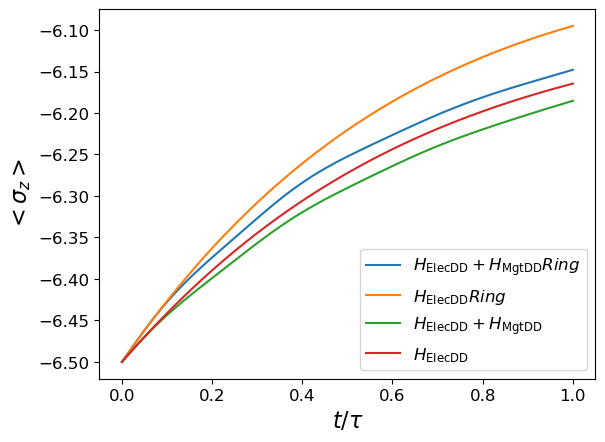

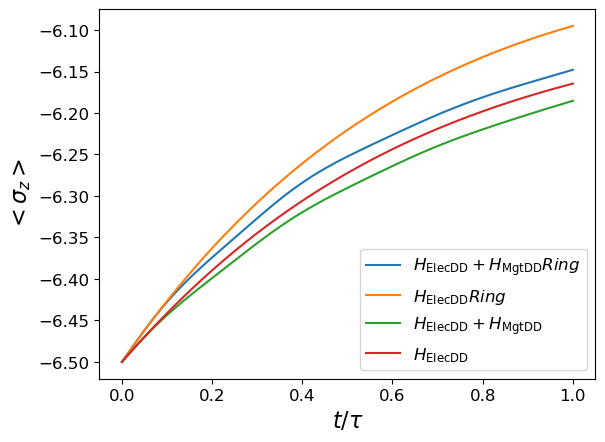

In [65]:
close("all")
figure()

PyPlot.rc("font", size = 12)

plot(T, mean_σz, label=L"$H_{\text{ElecDD}}+H_{\text{MgtDD}} Ring$")
plot(T, mean_σz_CS, label=L"$H_{\text{ElecDD}} Ring$")
#plot(T, mean_σz_ind, label="Independent Atoms", linestyle="--")
plot(T, mean_σz_square, label=L"$H_{\text{ElecDD}}+H_{\text{MgtDD}}$")
plot(T, mean_σz_CS_square, label=L"$H_{\text{ElecDD}}$")
#plot(T, mean_σz_ind, label="Independent Atoms", linestyle="--")
xlabel(L"t/\tau", fontsize=16)
ylabel(L"<σ_z>", fontsize=16)
legend()

#savefig("/Users/remy/Documents/Remy/ENSL_2024_2025/Stage_M2/Rapport_Stage_M2/Figures/Pop_decay_mean_sigmaz_phase_relationship_ZZComparison.pdf", bbox_inches="tight")

pygui(false); gcf()

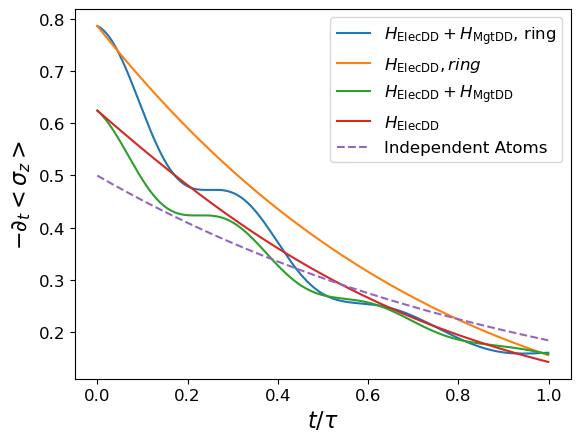

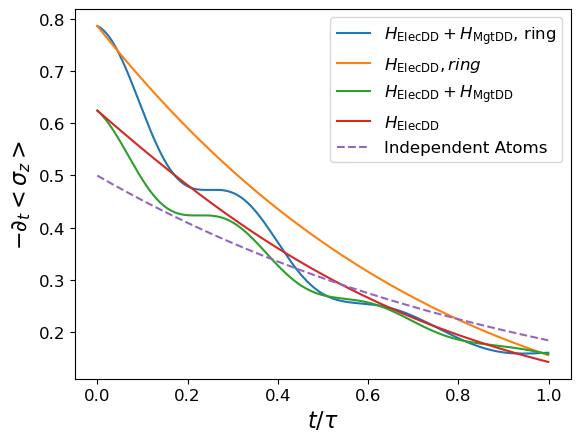

In [66]:
close("all")
figure()
plot(T[1:end-1], diff_σz, label=L"$H_{\text{ElecDD}}+H_{\text{MgtDD}}$, ring")
plot(T[1:end-1], diff_σz_CS, label=L"$H_{\text{ElecDD}}, ring$")
plot(T[1:end-1], diff_σz_square, label=L"$H_{\text{ElecDD}}+H_{\text{MgtDD}}$")
plot(T[1:end-1], diff_σz_CS_square, label=L"$H_{\text{ElecDD}}$")
plot(T[1:end-1], diff_σz_ind, label="Independent Atoms", linestyle="--")
xlabel(L"t/\tau", fontsize=16)
ylabel(L"-\partial_t{<σ_z>}", fontsize=16)
legend()

#savefig("/Users/remy/Documents/Remy/ENSL_2024_2025/Stage_M2/Rapport_Stage_M2/Figures/Pop_decay_diff_mean_sigmaz_phase_relationship_ZZComparison.pdf", bbox_inches="tight")

pygui(false); gcf()

In [67]:
#= matopen("data.mat", "w") do f
    write(f, "meansz", mean_σz)
    write(f, "meanszCS", mean_σz_CS)
    write(f, "meanszind", mean_σz_ind)
    write(f, "diffsz", diff_σz)
    write(f, "diffszCS", diff_σz_CS)
    write(f, "diffszind", diff_σz_ind)
end =#

In [68]:
#σz_array = [[real(expect(embed(bMB, i, σz67), ρ)) for ρ in ρt] for i = 1:N]